In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import skimage
from ipywidgets import IntProgress
from IPython.display import display
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import optimizers
from tensorflow.keras import losses

tf.__version__

'2.8.0'

In [2]:
vram = 12 # GB

gpus = tf.config.list_physical_devices('GPU')

tf.config.set_logical_device_configuration(
    gpus[0],
    [tf.config.LogicalDeviceConfiguration(memory_limit=vram*1024)])
print(len(gpus), "Physical GPUs Configured")

1 Physical GPUs Configured


In [3]:
image_dir = 'images/'
img_res = 128

loading_bar = IntProgress(min=0,max=len(os.listdir(image_dir)))
display(loading_bar)

X = []
y = []
for image_file in os.listdir(image_dir):
    raw_image = skimage.io.imread(image_dir+image_file)
    raw_image = skimage.transform.resize(raw_image,(img_res,img_res))

    lab_image = skimage.color.rgb2lab(raw_image)
    l = lab_image[:,:,0].reshape(img_res,img_res,1)/100
    ab = (lab_image[:,:,1:]+128)/255
    # np.dstack to re-combine colors

    X.append(l)
    y.append(ab)

    loading_bar.value += 1

X = np.array(X)
y = np.array(y)

IntProgress(value=0, max=1000)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.05)
dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(64)

In [50]:
generator = keras.Sequential()

generator.add(layers.Conv2D(16,kernel_size=(8),activation='relu',padding='same',input_shape=(img_res,img_res,1)))
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())
generator.add(layers.Conv2D(32,kernel_size=(8),activation='relu',padding='same'))
generator.add(layers.Conv2D(32,kernel_size=(8),activation='relu',padding='same'))
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())
generator.add(layers.Conv2D(64,kernel_size=(8),activation='relu',padding='same'))
generator.add(layers.Conv2D(64,kernel_size=(8),activation='relu',padding='same'))
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())
generator.add(layers.Conv2D(128,kernel_size=(8),activation='relu',padding='same'))
generator.add(layers.Conv2D(128,kernel_size=(8),activation='relu',padding='same'))
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())

generator.add(layers.Conv2DTranspose(64,kernel_size=(8),activation='relu',padding='same'))
generator.add(layers.Conv2DTranspose(64,kernel_size=(8),activation='relu',padding='same'))
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())
generator.add(layers.Conv2DTranspose(32,kernel_size=(8),activation='relu',padding='same'))
generator.add(layers.Conv2DTranspose(32,kernel_size=(8),activation='relu',padding='same'))
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())
generator.add(layers.Conv2DTranspose(16,kernel_size=(8),activation='relu',padding='same'))
generator.add(layers.Conv2DTranspose(16,kernel_size=(8),activation='relu',padding='same'))
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())
generator.add(layers.Conv2DTranspose(2,kernel_size=(8),activation='sigmoid',padding='same'))

generator_optimizer = tf.keras.optimizers.Adam( 0.0005 )

generator.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 128, 128, 16)      1040      
                                                                 
 batch_normalization_28 (Bat  (None, 128, 128, 16)     64        
 chNormalization)                                                
                                                                 
 leaky_re_lu_28 (LeakyReLU)  (None, 128, 128, 16)      0         
                                                                 
 conv2d_61 (Conv2D)          (None, 128, 128, 32)      32800     
                                                                 
 conv2d_62 (Conv2D)          (None, 128, 128, 32)      65568     
                                                                 
 batch_normalization_29 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                     

In [51]:
discriminator = keras.Sequential()

discriminator.add(layers.Conv2D(32,kernel_size=(8),activation='relu',padding='same',input_shape=(img_res,img_res,2)))
discriminator.add(layers.Conv2D(64,kernel_size=(8),activation='relu',padding='same'))
discriminator.add(layers.MaxPooling2D())
discriminator.add(layers.Conv2D(64,kernel_size=(8),activation='relu',padding='same'))
discriminator.add(layers.Conv2D(64,kernel_size=(8),activation='relu',padding='same'))
discriminator.add(layers.MaxPooling2D())
discriminator.add(layers.Conv2D(128,kernel_size=(8),activation='relu',padding='same'))
discriminator.add(layers.Conv2D(128,kernel_size=(8),activation='relu',padding='same'))
discriminator.add(layers.MaxPooling2D())
discriminator.add(layers.Conv2D(256,kernel_size=(8),activation='relu',padding='same'))
discriminator.add(layers.Conv2D(256,kernel_size=(8),activation='relu',padding='same'))
discriminator.add(layers.MaxPooling2D())

discriminator.add(layers.Flatten())
discriminator.add(layers.Dense(512,activation='relu'))
discriminator.add(layers.Dense(128,activation='relu'))
discriminator.add(layers.Dense(64,activation='relu'))
discriminator.add(layers.Dense(32,activation='relu'))
discriminator.add(layers.Dense(1,activation='sigmoid'))

discriminator_optimizer = tf.keras.optimizers.Adam(0.0005)

discriminator.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_67 (Conv2D)          (None, 128, 128, 32)      4128      
                                                                 
 conv2d_68 (Conv2D)          (None, 128, 128, 64)      131136    
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_69 (Conv2D)          (None, 64, 64, 64)        262208    
                                                                 
 conv2d_70 (Conv2D)          (None, 64, 64, 64)        262208    
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                 

In [52]:
cross_entropy = losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    total_loss = real_loss + fake_loss   
    return total_loss

def generator_loss(fake_output):
    total_loss = cross_entropy(tf.ones_like(fake_output),fake_output)
    return total_loss

In [53]:
@tf.function
def gen_step(gray_batch):

    with tf.GradientTape() as gen_tape:
        generated_batch = generator(gray_batch,training=True)
        generated_disc_output = discriminator(generated_batch,training=False)
        gen_loss = generator_loss(generated_disc_output)
      
    generator_gradients = gen_tape.gradient(gen_loss,generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients,generator.trainable_variables))

In [54]:
@tf.function
def disc_step(gray_batch,color_batch):
    
    with tf.GradientTape() as disc_tape:
        generated_batch = generator(gray_batch,training=False)
        generated_disc_output = discriminator(generated_batch,training=True)
        real_disc_output = discriminator(color_batch,training=True)
        disc_loss = discriminator_loss(real_disc_output,generated_disc_output)
    
    discriminator_gradients = disc_tape.gradient(disc_loss,discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,discriminator.trainable_variables))

In [55]:
epochs = 1
gen_per_epoch = 1
disc_per_epoch = 10

training_bar = IntProgress(min=0,max=epochs*(gen_per_epoch + disc_per_epoch))

display(training_bar)

for epoch in range(epochs):

    for _ in range(disc_per_epoch):
        for gray_batch,color_batch in dataset:
            disc_step(gray_batch,color_batch)
        training_bar.value += 1

    for _ in range(gen_per_epoch):
        for gray_batch,color_batch in dataset:
            gen_step(gray_batch)
        training_bar.value += 1

IntProgress(value=0, max=11)

<Figure size 432x288 with 0 Axes>

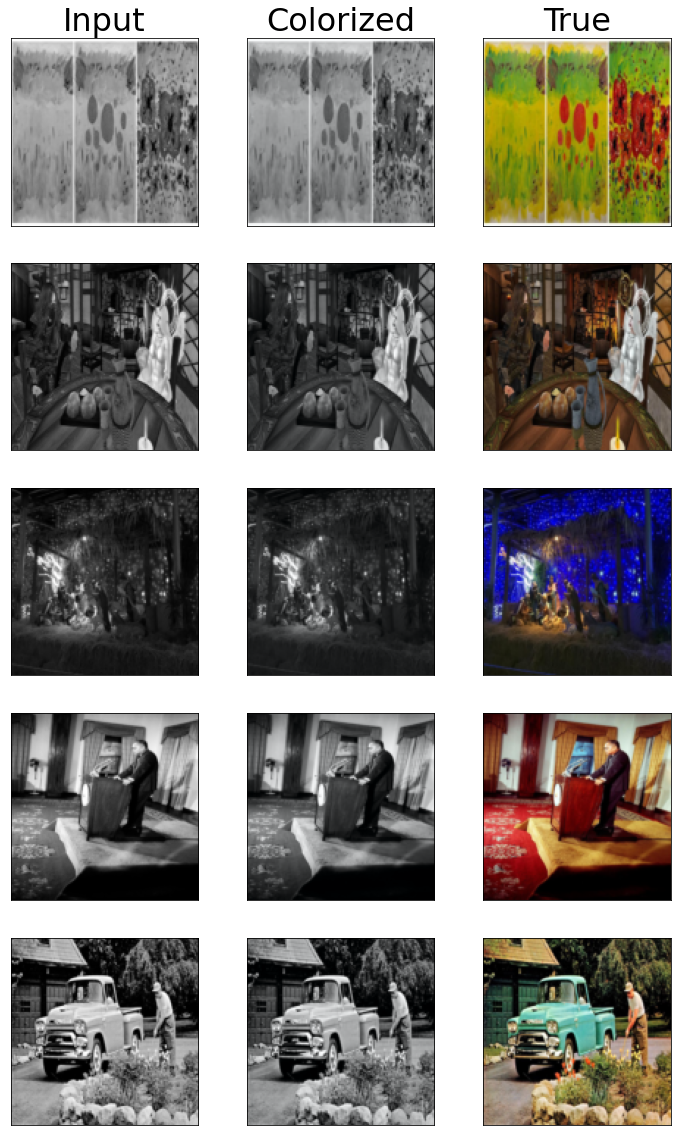

In [56]:
plt.tight_layout()
fig,ax = plt.subplots(5,3,figsize=(12,20))
for idx,row in enumerate(ax):
    y_pred = np.squeeze((generator(X_test[idx]).numpy()*255)-128)
    y_true = (y_test[idx]*255)-128
    X_res = X_test[idx]*100

    true_img = skimage.color.lab2rgb(np.dstack((X_res,y_true)))
    fake_img = skimage.color.lab2rgb(np.dstack((X_res,y_pred)))

    row[0].imshow(X_res,cmap='gray')
    row[1].imshow(fake_img)
    row[2].imshow(true_img)

    for axis in row:
        axis.set_xticks([])
        axis.set_yticks([])
fig.set_facecolor('#FFFFFF')
ax[0][0].set_title('Input',fontsize=32);
ax[0][1].set_title('Colorized',fontsize=32);
ax[0][2].set_title('True',fontsize=32);